# Using sardem for ISCE2 processing

While [ISCE2](https://github.com/isce-framework/isce2) has the `dem.py` script to create DEMs, you can use the DEMs produced by `sardem` tool in ISCE by setting the `-isce` or `--make-isce-xml` (for example, if you'd like to use the Copernicus DEM's, which aren't currently available through the ISCE DEM script). 

The `-isce` flag will produce the necessary  ".xml"/".vrt" files used by ISCE.

Note that ISCE is *not* installed as a dependency of `sardem`; you must separately `conda install -c conda-forge isce2` or see the ISCE README for full installation instructions to use this flag.

## Differences between sardem and ISCE's `dem.py` script:
The main differences between how a user requests a DEM with `sardem` and with `dem.py` are due to `sardem` following GDAL's bounding box convention.


1. From the help string, one usage of `dem.py` is :

> Stitch the requested files and apply EGM96 -> WGS84 correction (-c)
>
> dem.py -a stitch -b 31 33 -114 -113 -r -s 1 -c

We see that the order of the boundaries for ISCE is "SNWE" (south, north, west, east), while `sardem` uses `--bbox left bottom right top`, which means the order  is (west, south, east, north).
The `dem.py` script also currently allows only integer bounds, so that the entire SRTM tiles are stitched together. `sardem` allows any floating-point bbox.


2. In GDAL's bounding box convention, the four numbers refer to the **outer edge** of the image. In ISCE, the XML files point to the **center** of the pixels.

What this means in practice is that to completely replicate the output of 

`dem.py -a stitch -b 31 33 -114 -113 -r -s 1 -c`


the bounding box needs to be shifted up/left 1/2 a pixel:

`sardem --bbox -114.000138888888 31.000138888888 -113.000138888888 33.000138888888`

This is because the SRTM lat/lon numbers in the tile names refer to the pixel centers, so the tiles actually extend out 1/2 a pixel in all directions.
Also, the `dem.py` script leaves off the bottom/right row of pixels in the tile (hence a shift up+left, rather than a padding in all directions).


In [7]:
!dem.py -a stitch -b 31 33 -114 -113 -r -s 1 -c

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
curl -n  -L -c $HOME/.earthdatacookie -b $HOME/.earthdatacookie -k -f -O https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/N32W114.SRTMGL1.hgt.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8288k  100 8288k    0     0   486k      0  0:00:17  0:00:17 --:--:-- 2401k--:--     0
curl -n  -L -c $HOME/.earthdatacookie -b $HOME/.earthdatacookie -k -f -O https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/N31W114.SRTMGL1.hgt.zip
  % Total    % Re

In [44]:
!sardem -isce --bbox -114.000138888888 31.000138888888 -113.000138888888 33.000138888888 -o sardem_version.dem

[08/17 12:34:01] [INFO dem.py] Bounds: -114.000138888888 31.000138888888 -113.000138888888 33.000138888888
[08/17 12:34:01] [INFO download.py] /Users/staniewi/.cache/sardem/N32W114.hgt already exists, skipping.
[08/17 12:34:01] [INFO download.py] /Users/staniewi/.cache/sardem/N31W114.hgt already exists, skipping.
[08/17 12:34:01] [INFO dem.py] Cropping stitched DEM to boundaries
[08/17 12:34:03] [INFO dem.py] Rate = 1: No upsampling to do
[08/17 12:34:03] [INFO dem.py] Writing DEM to sardem_version.dem
[08/17 12:34:03] [INFO dem.py] Writing .dem.rsc file to sardem_version.dem.rsc
[08/17 12:34:03] [INFO dem.py] Creating ISCE2 XML file
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of t

In [45]:
!ls sardem_version*

sardem_version.dem     sardem_version.dem.vrt
sardem_version.dem.rsc sardem_version.dem.xml


The ".xml" and ".vrt" files were created since the `-isce` flag was passed.

We can see from the "startingvalue"s that `sardem` has shifted the convention to be pixel-centeres for these ISCE files, and that they match the `dem.py` values.

In [54]:
!grep -n4 'starting' sardem_version.dem.xml

30-        <property name="size">
31-            <value>3600</value>
32-            <doc>Coordinate size.</doc>
33-        </property>
34:        <property name="startingvalue">
35-            <value>-114.0</value>
36-            <doc>Starting value of the coordinate.</doc>
37-        </property>
38-    </component>
--
59-        <property name="size">
60-            <value>7200</value>
61-            <doc>Coordinate size.</doc>
62-        </property>
63:        <property name="startingvalue">
64-            <value>33.0</value>
65-            <doc>Starting value of the coordinate.</doc>
66-        </property>
67-    </component>


In [53]:
!grep -n4 'starting' demLat_N31_N33_Lon_W114_W113.dem.wgs84.xml

33-        <property name="size">
34-            <value>3600</value>
35-            <doc>Coordinate size.</doc>
36-        </property>
37:        <property name="startingvalue">
38-            <value>-114.0</value>
39-            <doc>Starting value of the coordinate.</doc>
40-        </property>
41-    </component>
--
62-        <property name="size">
63-            <value>7200</value>
64-            <doc>Coordinate size.</doc>
65-        </property>
66:        <property name="startingvalue">
67-            <value>33.0</value>
68-            <doc>Starting value of the coordinate.</doc>
69-        </property>
70-    </component>


In [26]:
from osgeo import gdal

ds = gdal.Open("demLat_N31_N33_Lon_W114_W113.dem.wgs84.vrt")
dem_isce = ds.GetRasterBand(1).ReadAsArray()
ds = None

ds = gdal.Open("sardem_version.dem")
dem_sardem = ds.GetRasterBand(1).ReadAsArray()
ds = None

In [31]:
(dem_sardem - dem_isce).max(), abs(dem_sardem - dem_isce).mean(),

(1, 0.012789197530864197)

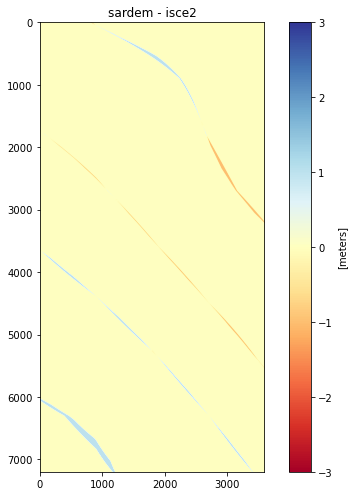

In [38]:
import matplotlib.pyplot as plt

vm = 3
fig, ax = plt.subplots(figsize=(7, 7))
axim = ax.imshow(dem_sardem - dem_isce, vmin=-vm, vmax=vm, cmap="RdYlBu")
cbar = fig.colorbar(axim)
cbar.set_label("[meters]")
ax.set_title("sardem - isce2")
fig.tight_layout()

The lines of +/-1 difference are due to integer truncation differenceds, and differences in the EGM96 -> WGS84 geoid conversion (since `sardem` uses GDAL for this step).